<a href="https://colab.research.google.com/github/sohammhatre001/J060-NLP-classwork/blob/master/NLP_M2J060_Final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **J060 NLP M2 : Soham Mhatre**

# **TOPIC MODELLING USING GENSIM MODEL and PyLDAvis**

**Reading data from github**

In [1]:
! wget https://github.com/amsurve/J050_sem6_nlp/blob/master/datasets/10k-german-news-articles.zip?raw=true
! mkdir newsarticles
! unzip 10k-german-news-articles.zip?raw=true -d newsarticles

--2020-03-03 17:34:17--  https://github.com/amsurve/J050_sem6_nlp/blob/master/datasets/10k-german-news-articles.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/amsurve/J050_sem6_nlp/raw/master/datasets/10k-german-news-articles.zip [following]
--2020-03-03 17:34:18--  https://github.com/amsurve/J050_sem6_nlp/raw/master/datasets/10k-german-news-articles.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/amsurve/J050_sem6_nlp/master/datasets/10k-german-news-articles.zip [following]
--2020-03-03 17:34:18--  https://media.githubusercontent.com/media/amsurve/J050_sem6_nlp/master/datasets/10k-german-news-articles.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.13


**Importing Libraries**

In [2]:
import numpy as np 
import pandas as pd 
import nltk
nltk.download('stopwords')
import re
from gensim.models import CoherenceModel
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
!pip install pyLDAvis

In [0]:
art=pd.read_csv("/content/newsarticles/Articles.csv")
posts=pd.read_csv("/content/newsarticles/Posts.csv")

**Merging Data: Left Join: Articles has many posts and therefore Article Id is key.**

In [5]:
left_merge=pd.merge(art,posts,on='ID_Article',how='left')
left_merge.shape

(1011773, 14)

In [6]:
art.shape

(12087, 5)

In [7]:
posts.shape

(1011773, 10)

In [8]:
print(art.columns)
print(posts.columns)

Index(['ID_Article', 'Path', 'publishingDate', 'Title', 'Body'], dtype='object')
Index(['ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt',
       'Status', 'Headline', 'Body', 'PositiveVotes', 'NegativeVotes'],
      dtype='object')


In [9]:
left_merge.columns

Index(['ID_Article', 'Path', 'publishingDate', 'Title', 'Body_x', 'ID_Post',
       'ID_Parent_Post', 'ID_User', 'CreatedAt', 'Status', 'Headline',
       'Body_y', 'PositiveVotes', 'NegativeVotes'],
      dtype='object')

In [0]:
arts_posts=left_merge.loc[left_merge['ID_Article']<101]


In [11]:
arts_posts.shape

(6081, 14)

In [0]:
#Body_x stands for article body
#Body_y stands for post body

In [13]:
arts_posts.isnull().sum()

ID_Article           0
Path                 0
publishingDate       0
Title                0
Body_x               0
ID_Post              0
ID_Parent_Post    2469
ID_User              0
CreatedAt            0
Status               0
Headline          4110
Body_y             298
PositiveVotes        0
NegativeVotes        0
dtype: int64

**Cleaning Functions: html to text, removing stopwords, tokeniser, convert_raw(one function for all)**


In [0]:

from bs4 import BeautifulSoup
def html_to_text(a):
    soup = BeautifulSoup(a)

    for script in soup(["script", "style"]):
        script.extract()   
  # get text
    text = soup.get_text()
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return text


gen_stops = set(stopwords.words('german'))
def remove_stopwords(s):
    s = re.sub(r'[0-9]', ' ', s)
    token = s.split()
    text = ' '.join([w for w in token if not w in gen_stops])
    return text

from nltk.tokenize import RegexpTokenizer
def tokenizeGerman(s):
    tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(s)
    return tokens

def convert_raw(s):
    s=html_to_text(s)
    s=remove_stopwords(s)
    s=tokenizeGerman(s)
    return s
    


In [15]:
len(arts_posts['Body_x'][0])

2924

In [16]:
print(len(html_to_text(arts_posts['Body_x'][0])))
print(len(remove_stopwords(html_to_text(arts_posts['Body_x'][0]))))


1929
1708


**Taking 2000 entries because PyLDAvis is slow**

In [0]:
art=art.iloc[0:2000]

In [0]:
art['CleanBody']=art['Body'].apply(convert_raw)

In [19]:
art.head()

,ID_Article,Path,publishingDate,Title,Body,CleanBody
0,1,Newsroom/User/Community,2012-05-26 03:00:19.23,Die Newsletter von derStandard.at,"<div class=""section"" id=""content-main"" itempro...","[Abonnieren, Sie, unserer, Newsletter, lassen,..."
1,2,Newsroom/User/Community/Regeln,2012-05-26 12:12:19.46,Werden Sie Teil von derStandard.at!,"<div class=""diashow"" id=""objectContent""><meta ...","[Werden, Sie, Teil, derStandard, at, Dezember,..."
2,3,Diverses/mobil,2013-11-22 12:15:00.00,Die Android App von derStandard.at,"<div class=""section"" id=""content-main"" itempro...","[Die, Smartphone, App, bietet, Nachrichten, Ec..."
3,4,Newsroom/User/mitmachen/Mitreden,2014-08-13 05:30:00.00,Welche Erfahrungen haben Sie als Linkshänder g...,"<div class=""section"" id=""content-main"" itempro...","[Wie, sieht, Ihr, Alltag, Linkshänder, aus, Er..."
4,5,Newsroom/User/mitmachen/Mitreden,2014-08-27 12:27:01.09,Wie haben Sie das Jahr 1989 erlebt?,"<div class=""section"" id=""content-main"" itempro...","[Erzählen, Sie, Ihren, Erlebnissen, rund, welt..."


In [20]:
art.shape

(2000, 6)

**GENSIM MODELS LDA for Body and Title**

In [21]:
doc=art['CleanBody']


# Creating corpus
dictionary = corpora.Dictionary(doc)
doc_term_matrix = [dictionary.doc2bow(text) for text in doc]

# Build LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=5, 
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

ldamodel.print_topics()


[(0,
  '0.009*"Die" + 0.005*"Der" + 0.003*"Das" + 0.003*"mehr" + 0.003*"wurde" + 0.003*"sei" + 0.002*"In" + 0.002*"werden" + 0.002*"APA" + 0.002*"wurden"'),
 (1,
  '0.010*"Die" + 0.005*"Das" + 0.005*"Der" + 0.004*"Prozent" + 0.004*"sei" + 0.003*"mehr" + 0.003*"wurde" + 0.003*"Österreich" + 0.003*"Sie" + 0.003*"Euro"'),
 (2,
  '0.007*"Die" + 0.004*"Das" + 0.004*"mehr" + 0.004*"Der" + 0.003*"werden" + 0.003*"wurde" + 0.002*"In" + 0.002*"Es" + 0.002*"Sie" + 0.002*"Wien"'),
 (3,
  '0.008*"Die" + 0.004*"Das" + 0.004*"Der" + 0.004*"Sie" + 0.003*"wurde" + 0.003*"In" + 0.003*"ist" + 0.002*"sei" + 0.002*"Es" + 0.002*"STANDARD"'),
 (4,
  '0.008*"Die" + 0.005*"Der" + 0.004*"Das" + 0.003*"werden" + 0.003*"Griechenland" + 0.003*"Euro" + 0.003*"Apple" + 0.003*"Tsipras" + 0.003*"EU" + 0.003*"mehr"')]

**These are the 5 most relevant topics prevalent in article body and the words given with that frequency score define each topic. A topic is defined by these words. We can therefore figure out which topics were the most prevalent in the articles given to us.**

In [22]:
#Compute Coherence Score
coherence_model_lda_body = CoherenceModel(model=ldamodel, texts=doc, dictionary=dictionary, coherence='c_v')
coherence_lda_body = coherence_model_lda_body.get_coherence()
print('\nCoherence Score: ', coherence_lda_body)


Coherence Score:  0.2729341744034048


In [0]:
art['Tok_Title']=art['Title'].apply(convert_raw)

In [24]:
art['Tok_Title'].head()

0                  [Die, Newsletter, derStandard, at]
1                [Werden, Sie, Teil, derStandard, at]
2                [Die, Android, App, derStandard, at]
3    [Welche, Erfahrungen, Sie, Linkshänder, gemacht]
4                            [Wie, Sie, Jahr, erlebt]
Name: Tok_Title, dtype: object

In [25]:

title_doc=art['Tok_Title']
# Creating corpus
title_dict = corpora.Dictionary(title_doc)
title_term_matrix = [title_dict.doc2bow(text) for text in title_doc]

# Build LDA model
lda_model_title = gensim.models.ldamodel.LdaModel(corpus=title_term_matrix,
                                           id2word=title_dict,
                                           num_topics=5, 
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


lda_model_title.print_topics()


[(0,
  '0.007*"Apple" + 0.004*"Der" + 0.004*"Wie" + 0.003*"Jahre" + 0.003*"US" + 0.003*"Die" + 0.003*"ORF" + 0.003*"mehr" + 0.002*"Iran" + 0.002*"Music"'),
 (1,
  '0.005*"Die" + 0.004*"EU" + 0.003*"US" + 0.003*"Österreich" + 0.003*"vier" + 0.003*"Wiener" + 0.002*"kommt" + 0.002*"Der" + 0.002*"geht" + 0.002*"Wie"'),
 (2,
  '0.005*"Das" + 0.004*"Ein" + 0.004*"Wien" + 0.004*"Österreich" + 0.004*"Griechenland" + 0.004*"Euro" + 0.004*"Wiener" + 0.003*"SPÖ" + 0.003*"Die" + 0.002*"Wie"'),
 (3,
  '0.006*"Die" + 0.003*"EU" + 0.003*"zurück" + 0.002*"erneut" + 0.002*"neue" + 0.002*"E" + 0.002*"Griechenland" + 0.002*"Drei" + 0.002*"Facebook" + 0.002*"Team"'),
 (4,
  '0.004*"Wien" + 0.004*"ab" + 0.003*"Prozess" + 0.003*"US" + 0.003*"Die" + 0.002*"Der" + 0.002*"mehr" + 0.002*"China" + 0.002*"Was" + 0.002*"Millionen"')]

In [26]:
#Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_title, texts=title_doc, dictionary=title_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.741207204099924


The most prevalent topics have also been found out for title and their words.

 **The Coherence Score gives us how good a given topic model is.**

# **pyLDAvis plots for tokenised title and body**

In [27]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda_model_title, title_term_matrix, title_dict)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


**pyLDAvis is taking too long.**

In [0]:
lda_display_body = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.display(lda_display_body)

In case you cannot see the pyLDAvis result. Here is proof.

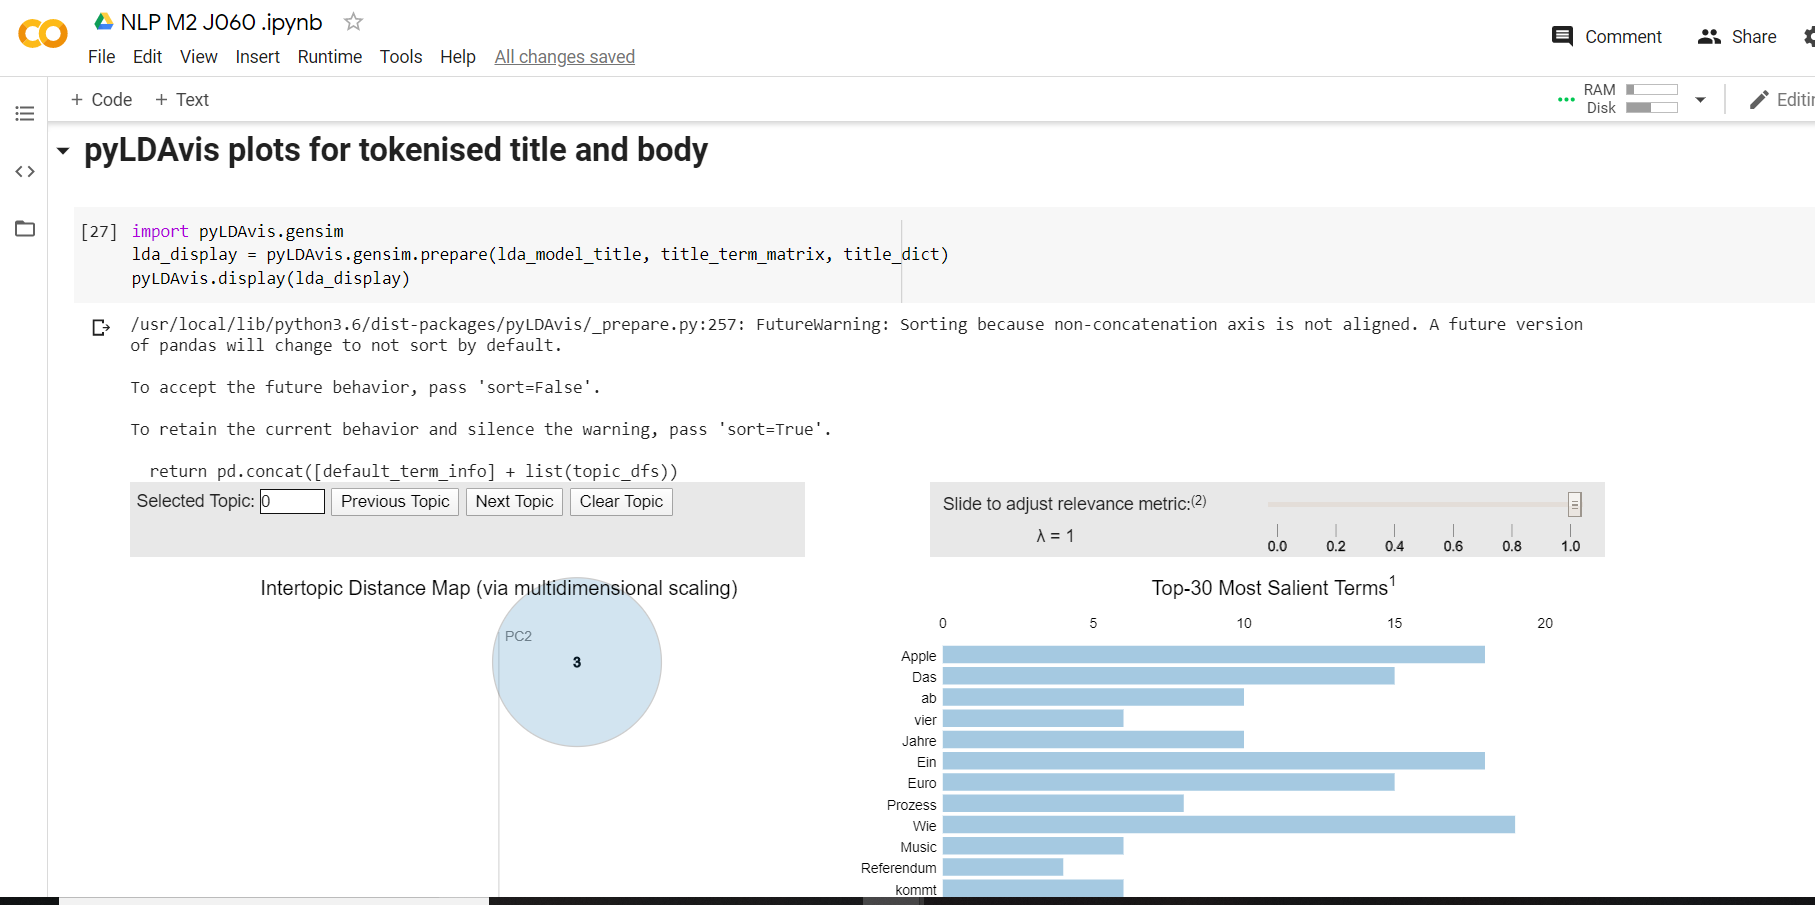

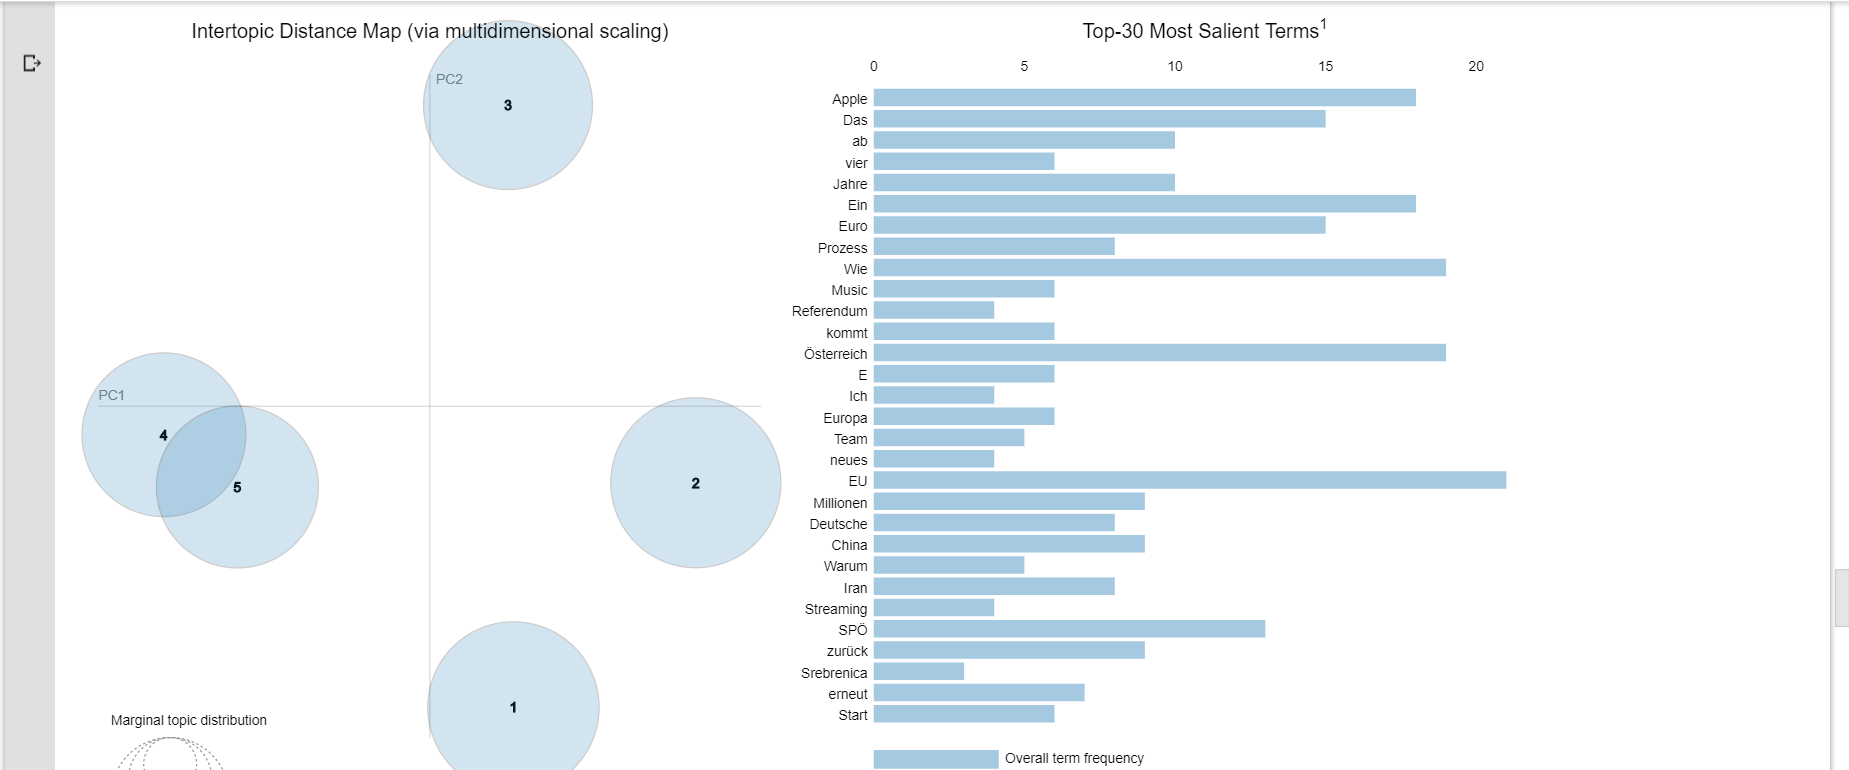